# Trace simulator experiments

This is a trace simulator.

1. We first start creating a NUMBER_OF_TOWERS towers in a random distribution.
2. Then we generate random traces for NUMBER_OF_USERS users through a number of CYCLES.
3. Finally we aggregate the data, the number of users for each tower in each cycle.

To generate random traces we take into account the distances between the towers and the cycle number (a.k.a. hours)

In [1]:
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Constants

In [26]:
NUMBER_OF_TOWERS = 100
NUMBER_OF_USERS = 100
CYCLES = 24

#
# The probability of jumping to another tower when its
# distance is within one of these distance percentiles.
#
PERCENTILES_PROB = [
    (0.05, 0.75),
    (0.15, 0.125),
    (0.30, 0.09375),
    (1.00, 0.03125),
]

EXPANDER = 1
SIGMA = 0.05

### Generator utils

In [3]:
def distance(p1, p2):
    """Distance between two points"""
    return math.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))

def get_random_trace(distances):
    """Generates an array of length CYCLES
    
    Each element of the returned array represents a tower of a user's trace
    """
    towers_ids = np.arange(NUMBER_OF_TOWERS)
    
    trace = []
    for cycle in range(CYCLES):
        if cycle == 0:
            # For the first towers the chance of selecting a tower is equally distributed
            trace.append(np.random.choice(towers_ids))
        else:
            #
            # For the next tower, the probability changes depending on the distance between
            # the last tower and the others.
            #
            # Also, we take into account the cycle number, so there's always a probability of
            # switching towers or not.
            #
            last_tower = trace[cycle - 1]
            
            # Night vs. Not-night probabilities
            switch_tower_prob = [0.2, 0.8] if cycle in range(0, 7) else [0.5, 0.5]

            if np.random.choice([True, False], p=switch_tower_prob):
                #
                # Get distances of last tower to the rest and
                # prevents the same last_tower from being selected
                #
                last_tower_dist = distances[last_tower].drop(last_tower)

                # Define the distances quantiles for the percentiles defined in the settings
                dist_quantiles = np.array([last_tower_dist.quantile(p) for p, _ in PERCENTILES_PROB])

                # For each distance, determine in which quantile that distance fits
                towers_prob = np.array([
                    PERCENTILES_PROB[np.argmin(d >= dist_quantiles + 0.00001)][1]
                    for d in last_tower_dist
                ])

                #
                # Equally divide the percentile probability
                # by the number of towers that fit in that group.
                #
                # For example, if 5 towers fit in the first percentile (top 5%), and the probability
                # for that group is of 0.25, then each tower has a 0.05 (= 0.25 / 5) chance of
                # being the following tower.
                #
                prob_items, prob_items_counts = np.unique(towers_prob, return_counts=True)
                for prob_item, prob_item_count in zip(prob_items, prob_items_counts):
                    towers_prob[towers_prob == prob_item] /= prob_item_count

                # Select a random tower taking into account the probabilities
                possible_towers_ids = distances.index.drop(last_tower)
                trace.append(np.random.choice(possible_towers_ids, p=towers_prob))
            else:
                trace.append(last_tower)
    
    return trace

def xamtfos(x, sig):
    aux = (1 / (np.sqrt(2 * np.pi * sig ** 2)))
    return -aux * (np.e ** -(x ** 2 / (2 * (sig ** 2)))) + aux + 1

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def generate_probabilities(dists):
#     normalizer = dists.max().max() / 2 * EXPANDER
    """Generate a matrix of probilities to go from """
    for i in range(NUMBER_OF_TOWERS):
        for j in range(NUMBER_OF_TOWERS):
            dists[i][j] = -1 * dists[i][j] * (xamtfos(dists[i][j], SIGMA)) * EXPANDER
    normalizer = dists.max().max() / 2
    dists -= normalizer
    return np.array([softmax(dists[i]) for i in range(NUMBER_OF_TOWERS)])

def generate_weighted_user_trace(probs):
    towers_ids = np.arange(NUMBER_OF_TOWERS)
    
    trace = []
    for cycle in range(CYCLES):
        if cycle == 0:
            # For the first towers the chance of selecting a tower is equally distributed
            trace.append(np.random.choice(towers_ids))
        else:
            last_tower = trace[cycle - 1]
            trace.append(np.random.choice(towers_ids, p=probs[last_tower]))
    
    return trace

def generate_weighted_users_traces(probs):
    return np.array([generate_weighted_user_trace(probs) for _ in range(NUMBER_OF_USERS)])

def generate_user_traces(distances):
    return np.array([get_random_trace(distances) for _ in range(NUMBER_OF_USERS)])

def generate_aggregate_data(traces):
    """Returns how many users were in each step of the cycle based on traces"""
    output = np.zeros((NUMBER_OF_TOWERS, CYCLES))
    for tower in range(NUMBER_OF_TOWERS):
        for user in range(NUMBER_OF_USERS):
            for time in range(CYCLES):
                output[tower][time] += traces[user][time] == tower
    return output

### Generate towers with random positions

In [4]:
towers = np.random.rand(NUMBER_OF_TOWERS, 2)

In [5]:
towers.shape

(100, 2)

### Plot towers positions

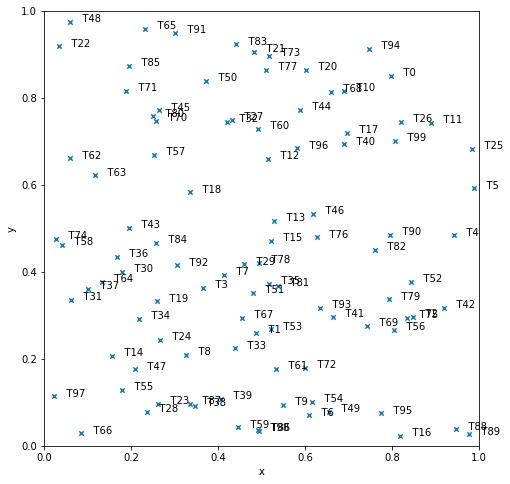

In [6]:
df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(8, 8), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

plt.gca().set_aspect('equal', adjustable='box')

### Calculate the distances between towers for each tower

In [7]:
distances = pd.DataFrame([
    [distance(towers[i], towers[j]) for j in range(NUMBER_OF_TOWERS)] for i in range(NUMBER_OF_TOWERS)
])

### Show example of tower distance probabilities

In [ ]:
tower_id = 4
tower_dists = distances[tower_id]
dist_quantiles = np.array([tower_dists.quantile(p) for p, _ in PERCENTILES_PROB])
print('Distance quantiles:', dist_quantiles)

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

for r in dist_quantiles:
    ax.add_artist(plt.Circle(towers[tower_id], r, color='r', alpha=1.0 / len(dist_quantiles)))
    
plt.gca().set_aspect('equal', adjustable='box')

## Generate traces based on location and velocity
we will modify the distance matrix to express the jump from one tower to another as a probability using the softmax function

In [27]:
probabilities = generate_probabilities(np.copy(distances.as_matrix()))

In [28]:
probabilities[0].max() == probabilities[0,0]

True

In [21]:
probabilities[0]

array([0.07915834, 0.00283724, 0.00494228, 0.00308003, 0.0110791 ,
       0.01603614, 0.0014395 , 0.00402944, 0.00149802, 0.00148605,
       0.05755561, 0.04827363, 0.01458353, 0.0093449 , 0.00084951,
       0.00766862, 0.00127555, 0.04130771, 0.00553696, 0.00189919,
       0.03352685, 0.0161259 , 0.00174308, 0.00078616, 0.00141947,
       0.02362511, 0.0588839 , 0.01197338, 0.0006781 , 0.00510254,
       0.00174003, 0.00089711, 0.0112501 , 0.00215845, 0.00142407,
       0.00497637, 0.00182687, 0.00113253, 0.00097185, 0.0011992 ,
       0.03465281, 0.00462894, 0.00515804, 0.00245894, 0.02790509,
       0.00538509, 0.01288054, 0.00090897, 0.00190545, 0.00156895,
       0.00949273, 0.00415097, 0.0073546 , 0.0031776 , 0.00169025,
       0.00068955, 0.00431209, 0.004509  , 0.00114106, 0.00097645,
       0.01545181, 0.00214603, 0.00176211, 0.00220056, 0.00135099,
       0.00448253, 0.00034721, 0.00304207, 0.04767598, 0.00444245,
       0.00507711, 0.0037637 , 0.00241141, 0.01950485, 0.00110

In [29]:
pd.DataFrame(probabilities).describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.008592,0.011737,0.010765,0.010907,0.007747,0.007743,0.010028,0.011307,0.010622,0.010667,...,0.009374,0.008586,0.010538,0.010541,0.007694,0.008512,0.010472,0.006789,0.009589,0.010008
std,0.026094,0.017537,0.025991,0.015725,0.026617,0.032084,0.022886,0.016564,0.016784,0.021177,...,0.021479,0.026294,0.016631,0.017017,0.026009,0.026662,0.018890,0.030141,0.022797,0.025629
min,0.000016,0.000180,0.000028,0.000539,0.000037,0.000017,0.000024,0.000713,0.000139,0.000038,...,0.000114,0.000011,0.000301,0.000127,0.000013,0.000011,0.000171,0.000013,0.000030,0.000039
25%,0.000119,0.001240,0.000282,0.001680,0.000173,0.000104,0.000285,0.002356,0.000704,0.000373,...,0.000557,0.000098,0.001517,0.001319,0.000089,0.000175,0.000901,0.000074,0.000216,0.000270
50%,0.000667,0.005050,0.001319,0.005431,0.000777,0.000488,0.001989,0.005367,0.003087,0.002762,...,0.002140,0.000500,0.005006,0.003925,0.000452,0.000682,0.003226,0.000345,0.001701,0.000903
75%,0.003750,0.015358,0.005144,0.013218,0.003406,0.002307,0.006869,0.012775,0.013542,0.007833,...,0.007296,0.004039,0.013016,0.015267,0.003419,0.004319,0.012599,0.002362,0.006923,0.005266
max,0.198567,0.091398,0.130677,0.101456,0.235366,0.274556,0.126333,0.095355,0.110302,0.113685,...,0.156006,0.201341,0.111060,0.110641,0.220430,0.194472,0.126682,0.275161,0.129341,0.162633


In [23]:
probabilities[2]

array([0.00380918, 0.01003869, 0.06100997, 0.00539107, 0.02353263,
       0.01203132, 0.01182189, 0.00662026, 0.00437309, 0.01006963,
       0.00406751, 0.00651735, 0.00525408, 0.00881362, 0.00187633,
       0.00968956, 0.01584875, 0.00647975, 0.00327341, 0.00321279,
       0.00278782, 0.00175893, 0.00037095, 0.00278031, 0.00333453,
       0.0079561 , 0.00647987, 0.00285374, 0.00240374, 0.00802198,
       0.00209028, 0.00120059, 0.00278898, 0.00767298, 0.00263493,
       0.01130047, 0.00190497, 0.00145199, 0.00410788, 0.00555118,
       0.00728241, 0.02818391, 0.0524679 , 0.00201374, 0.00406798,
       0.00143323, 0.01193928, 0.00238037, 0.00034257, 0.014447  ,
       0.00167004, 0.0095203 , 0.05166667, 0.01203179, 0.01357893,
       0.00195804, 0.05631347, 0.00183574, 0.00100433, 0.00570352,
       0.00372905, 0.01139406, 0.00079919, 0.00112684, 0.00169108,
       0.00067145, 0.00107471, 0.00864537, 0.00391454, 0.04563828,
       0.00150081, 0.00092487, 0.01591548, 0.00200155, 0.00092

## Generate random user traces

We take into account the distances between towers in order to select the following towers

In [30]:
# %time random_traces = generate_user_traces(distances)
%time random_traces = generate_weighted_users_traces(probabilities)

CPU times: user 74.9 ms, sys: 3.89 ms, total: 78.8 ms
Wall time: 77.7 ms


In [31]:
%time aggregated_data = generate_aggregate_data(random_traces)

print(f'Traces shape: {random_traces.shape}\t aggregated_data shape: {aggregated_data.shape}')

CPU times: user 791 ms, sys: 8.96 ms, total: 799 ms
Wall time: 807 ms
Traces shape: (100, 24)	 aggregated_data shape: (100, 24)


In [15]:
random_traces[0]

array([49, 49, 54, 49, 49, 49, 54, 72, 61, 61, 61, 61, 61, 61, 61,  9,  6,
        6,  6,  6, 61, 61, 61, 35])

In [ ]:
aggregated_data

In [ ]:
# Check that the sum of users at every cycle is the same
all(aggregated_data.sum(axis=0) == NUMBER_OF_USERS)

## Draw some random user traces

Cycle #0: Staying in tower T17
Cycle #1: Switching from T17 to T60
Cycle #2: Switching from T60 to T27
Cycle #3: Switching from T27 to T44
Cycle #4: Switching from T44 to T51
Cycle #5: Switching from T51 to T7
Cycle #6: Switching from T7 to T34
Cycle #7: Switching from T34 to T97
Cycle #8: Switching from T97 to T66
Cycle #9: Switching from T66 to T55
Cycle #10: Switching from T55 to T19
Cycle #11: Switching from T19 to T84
Cycle #12: Switching from T84 to T7
Cycle #13: Staying in tower T7
Cycle #14: Switching from T7 to T14
Cycle #15: Switching from T14 to T23
Cycle #16: Switching from T23 to T24
Cycle #17: Switching from T24 to T66
Cycle #18: Switching from T66 to T74
Cycle #19: Switching from T74 to T34
Cycle #20: Switching from T34 to T19
Cycle #21: Switching from T19 to T15
Cycle #22: Switching from T15 to T51


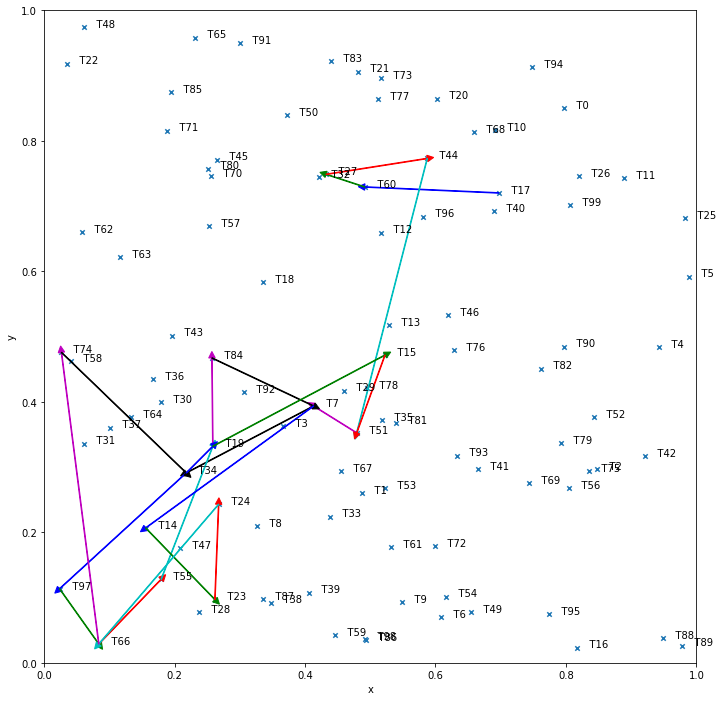

In [32]:
from itertools import cycle

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

cycol = cycle('bgrcmk')

trace = random_traces[1]
for i in range(CYCLES - 1):
    if trace[i] == trace[i + 1]:
        print(f'Cycle #{i}: Staying in tower T{trace[i]}')
        continue
    x1, y1 = towers[trace[i]]
    x2, y2 = towers[trace[i + 1]]

    print(f'Cycle #{i}: Switching from T{trace[i]} to T{trace[i + 1]}')
    color = next(cycol)
    ax.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.01, head_length=0.01, fc=color, ec=color)

plt.gca().set_aspect('equal', adjustable='box')